In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils_v1a import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils_v1a import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from testCases import *

### Creating Minibatches Of Dataset

In [2]:
def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
    np.random.seed(seed) 
    m = X.shape[1]
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))
    
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(num_complete_minibatches):
        
        mini_batch_X = shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        
        mini_batch_X = shuffled_X[:,mini_batch_size*(num_complete_minibatches):m]
        mini_batch_Y = shuffled_Y[:,mini_batch_size*(num_complete_minibatches):m]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches

### Loading Dataset
The dataset is named "moons" because the data from each of the two classes looks a bit like a crescent-shaped moon.

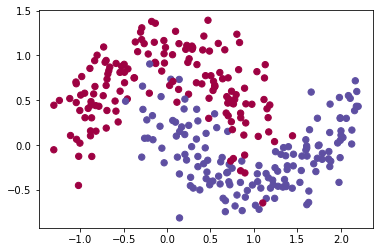

In [3]:
train_X, train_Y = load_dataset()

## Adam

Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp (described in lecture) and Momentum. 

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

As usual, we will store all parameters in the `parameters` dictionary  

## Initialize 
Adam variables $v, s$ which keep track of the past information.

**Instruction**: The variables $v, s$ are python dictionaries that need to be initialized with arrays of zeros. Their keys are the same as for `grads`, that is:
for $l = 1, ..., L$:
```python
v["dW" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l+1)])
v["db" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l+1)])
s["dW" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l+1)])
s["db" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l+1)])

```

In [4]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters['W'+str(l+1)].shape[0],parameters['W'+str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters['b'+str(l+1)].shape[0],parameters['b'+str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters['W'+str(l+1)].shape[0],parameters['W'+str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters['b'+str(l+1)].shape[0],parameters['b'+str(l+1)].shape[1]))
    
    return v, s

### Updating Parameters
Implement the parameters update with Adam. Recall the general update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{W^{[l]}} = \beta_1 v_{W^{[l]}} + (1 - \beta_1) \frac{\partial J }{ \partial W^{[l]} } \\
v^{corrected}_{W^{[l]}} = \frac{v_{W^{[l]}}}{1 - (\beta_1)^t} \\
s_{W^{[l]}} = \beta_2 s_{W^{[l]}} + (1 - \beta_2) (\frac{\partial J }{\partial W^{[l]} })^2 \\
s^{corrected}_{W^{[l]}} = \frac{s_{W^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{W^{[l]}}}{\sqrt{s^{corrected}_{W^{[l]}}}+\varepsilon}
\end{cases}$$


**Note** that the iterator `l` starts at 0 in the `for` loop while the first parameters are $W^{[1]}$ and $b^{[1]}$. You need to shift `l` to `l+1` when coding.

In [5]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):

    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l+1)] = beta1*v["dW"+str(l+1)] + (1-beta1)*grads['dW'+str(l+1)]
        v["db" + str(l+1)] = beta1*v["db"+str(l+1)] + (1-beta1)*grads['db'+str(l+1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-(beta1**t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1-(beta1**t))

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta2*s["dW"+str(l+1)] + (1-beta2)*np.square(grads['dW'+str(l+1)])
        s["db" + str(l+1)] = beta2*s["db"+str(l+1)] + (1-beta2)*np.square(grads['db'+str(l+1)])

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-(beta2**t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-(beta2**t))

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*(v_corrected["dW" + str(l+1)])/(np.sqrt(s_corrected["dW" + str(l+1)])+epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*(v_corrected["db" + str(l+1)])/(np.sqrt(s_corrected["db" + str(l+1)])+epsilon)
        

    return parameters, v, s

### Model

In [24]:
def model(X, Y, layers_dims,learning_rate, mini_batch_size,beta1, beta2,  epsilon,epochs):

    L = len(layers_dims)                             
    t = 0                            
    seed = 10                        
    m = X.shape[1]                   
    
    parameters = initialize_parameters(layers_dims)

    v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            t = t + 1 # Adam counter
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,t, learning_rate, beta1, beta2,  epsilon)

    return parameters

### Architecture

In [25]:
layers_dims = [train_X.shape[0], 5, 2, 1]

In [26]:
import time

### Training

In [27]:
tic = time.time()
final_parameters = model(train_X, train_Y, layers_dims,learning_rate=0.0007,mini_batch_size=64,beta1=0.9,beta2=0.999,epsilon=1e-8,epochs=10000)
toc = time.time()

print('Training time : ',toc-tic,'seconds')

Training time :  8.681477069854736 seconds


### Prediction

In [28]:
predictions = predict(train_X, train_Y, final_parameters)

Accuracy: 0.94


### Decision_boundry

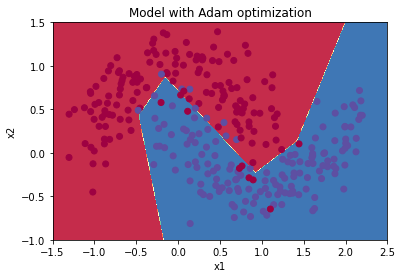

In [29]:
# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)